## SCOTCH Example Workflow

This notebook is a tutorial for SCOTCH (*S*ingle *C*ell *O*rthogonal matrix *T*ri-factorzation for *C*lustering *H*igh-dimensional data). SCOTCH uses non-negative matrix tri-factorization to cluster cells and define gene sets which drive each cell clusters expression profile. 

In [11]:
import SCOTCH
import pandas as pd 
import numpy as np 
import anndata as ad
import scanpy as sc
import pooch
import torch

import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec

### Loading single cell data 

SCOTCH allows loading through three interfaces, plain text files, anndata objects, or pytorch pt. files. For this example we will work with the exampledata scat is used for the scverse and scanpy tutorials. The data that are using is the 2021 NeurIPS benchmarking dataset. The samples used in this data were measured with the 10X multiome gene expression and chromatin accessibility kit. We will focus on the filtered expression matrices. That data contains ~16,000 from two different donors and span 36,601 genes. 

For this tutorial we utilize the begging of the guide for scanpy which downloads the data into a standard adata object (adata). 

In [2]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [3]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())

/mnt/dv/wid/projects5/Roy-singlecell/spencer_work/.conda/envs/Pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


s1d1    8785
s1d3    8340
Name: sample, dtype: int64


/mnt/dv/wid/projects5/Roy-singlecell/spencer_work/.conda/envs/Pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/mnt/dv/wid/projects5/Roy-singlecell/spencer_work/.conda/envs/Pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Initializing a SCOTCH object

Now we can initialize SCOTCH. SCOTCH is a matrix tri factorization approach that estimates the data as multiplication of three matrices. 

$X \approx U S V^{T}$ where $U$ is a near orthogonal matrix which is used to cluster the cell space, $V$ is a near orthogonal matrix which is used to cluster the gene space, and $S$ is relationsip matrix which relates gene and cell clusters. 

To start SCOTCH we need to initialize a SCOTCH object, and specify the number of cluster we want to use for the cell space (k1), and the number of cluster for the gene space (k2). We can also specify regularization parameters such as $\lambda_u$ or $\lambda_v$ which can be tuned to improve the orthgonality of the cell and gene clusters respectively. 


In [4]:
scotch = SCOTCH.SCOTCH(k1 = 15, k2 = 30, max_l_u = 5000, max_l_v = 5000, term_tol = 1e-4, var_lambda= True, device = "cuda:1")
scotch.addDataFromAData(adata)
scotch.send_to_gpu()

In [5]:
scotch.fit()

Iter: 1	Iter Time: 28.438	Total Time: 28.438	Error: 9.670e+09	Relative Delta Residual: 7.415e-01
Iter: 2	Iter Time: 14.224	Total Time: 42.663	Error: 6.325e+09	Relative Delta Residual: 3.459e-01
Iter: 3	Iter Time: 14.227	Total Time: 56.889	Error: 5.651e+09	Relative Delta Residual: 1.065e-01
Iter: 4	Iter Time: 14.226	Total Time: 71.116	Error: 5.052e+09	Relative Delta Residual: 1.060e-01
Iter: 5	Iter Time: 14.227	Total Time: 85.343	Error: 4.845e+09	Relative Delta Residual: 4.099e-02
Iter: 6	Iter Time: 14.226	Total Time: 99.569	Error: 4.762e+09	Relative Delta Residual: 1.697e-02
Iter: 7	Iter Time: 14.225	Total Time: 113.795	Error: 4.722e+09	Relative Delta Residual: 8.494e-03
Iter: 8	Iter Time: 14.226	Total Time: 128.020	Error: 4.699e+09	Relative Delta Residual: 4.928e-03
Iter: 9	Iter Time: 14.226	Total Time: 142.246	Error: 4.684e+09	Relative Delta Residual: 3.127e-03
Iter: 10	Iter Time: 14.226	Total Time: 156.472	Error: 4.674e+09	Relative Delta Residual: 2.150e-03
Iter: 11	Iter Time: 14.22

In [6]:
scotch.send_to_cpu()
adata = scotch.addScotchEmbeddingsToAnnData(adata)

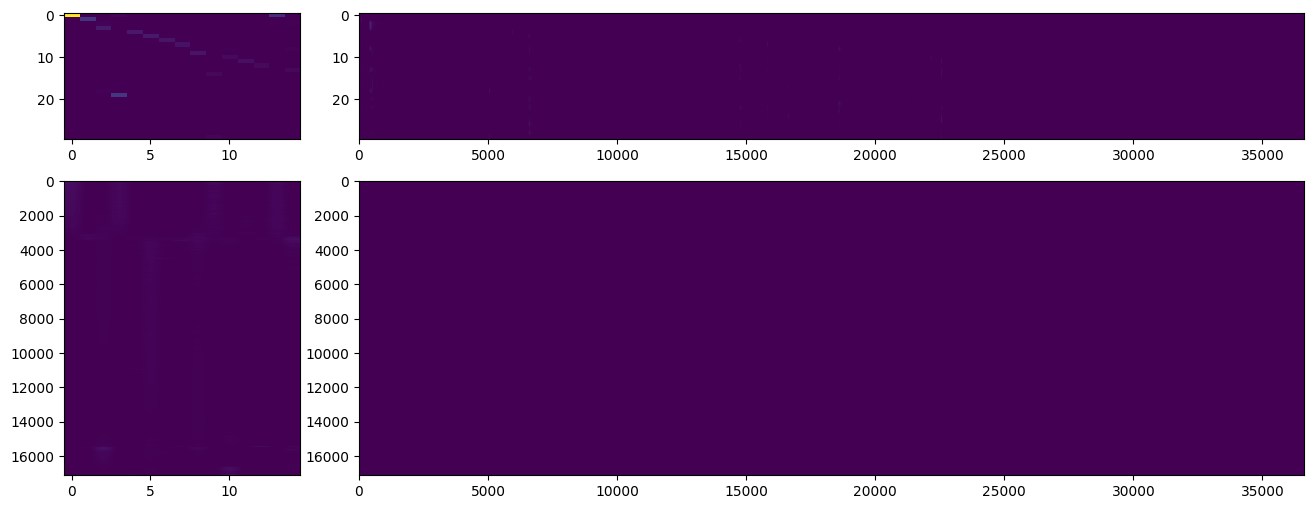

In [55]:
sorted_indices = sorted(range(scotch.U.size(0)), key=lambda i: scotch.U[i].tolist(), reverse=True)
sort_U = scotch.U[sorted_indices]

V = scotch.V.t()
sorted_indices = sorted(range(V.size(0)), key=lambda i: V[i].tolist(), reverse=True)
sort_V = V[sorted_indices]
sort_V = sort_V.t()

fig = plt.figure(figsize=(16,6))
grids = GridSpec.GridSpec(2, 2, wspace=0.1, width_ratios = (0.2, 0.8), height_ratios = (0.3, 0.7))

ax1 = fig.add_subplot(grids[1, 0])
ax1.imshow(sort_U.detach().numpy(), norm = "linear", aspect="auto", cmap='viridis')
#ax1.set_title("U Matrix")

# Visualize S matrix
ax2 = fig.add_subplot(grids[0, 0])
ax2.imshow(scotch.S.t().detach().numpy(), norm = "linear", aspect="auto", cmap='viridis')
#ax2.set_title("S Matrix")

# Visualize V matrix
ax3 = fig.add_subplot(grids[0, 1])
ax3.imshow(sort_V.detach().numpy(), norm = "linear", aspect="auto", cmap='viridis')
#ax3.set_title("V Matrix")

# Visualize X matrix
ax4 = fig.add_subplot(grids[1, 1])
ax4.imshow((sort_U @ scotch.S @ sort_V).detach().numpy() , norm = "linear", aspect="auto", cmap='viridis')
#ax4.set_title("X Matrix")

plt.show()

In [ ]:
sc.pl.umap(
    adata,
    color="cell_clusters",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

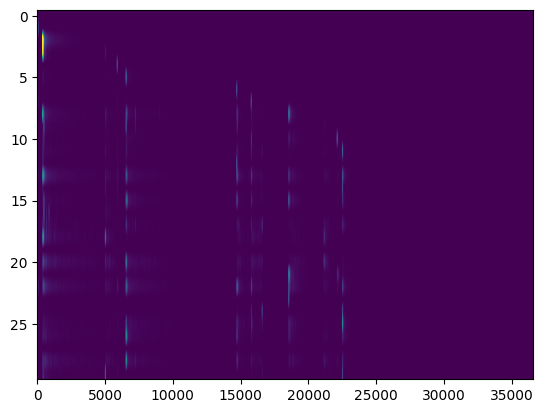

In [65]:
plt.imshow(sort_V.detach().numpy(), norm = "linear", aspect="auto", cmap='viridis', vmin = 0, vmax = 0.05)

In [56]:
sort_U

tensor([[1.3823e-01, 1.6932e-02, 0.0000e+00,  ..., 0.0000e+00, 6.3107e-03,
         0.0000e+00],
        [5.8391e-02, 7.4757e-03, 0.0000e+00,  ..., 0.0000e+00, 2.4773e-02,
         0.0000e+00],
        [5.5440e-02, 7.0851e-03, 0.0000e+00,  ..., 0.0000e+00, 1.9952e-02,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.6997e-04,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.2165e-04,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [33]:
sort_U, _ = torch.sort(scotch.U, dim = 0)

In [54]:
sort_U.detach().numpy()

array([[1.3822724e-01, 1.6931845e-02, 0.0000000e+00, ..., 0.0000000e+00,
        6.3107358e-03, 0.0000000e+00],
       [5.8391023e-02, 7.4757403e-03, 0.0000000e+00, ..., 0.0000000e+00,
        2.4773268e-02, 0.0000000e+00],
       [5.5440336e-02, 7.0850751e-03, 0.0000000e+00, ..., 0.0000000e+00,
        1.9952470e-02, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.6997123e-04, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.2164525e-04, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [44]:
ç

array([[0.13822724, 0.36953995, 0.12310214, ..., 0.6733475 , 0.11960241,
        0.18727489],
       [0.05839102, 0.33568355, 0.07895909, ..., 0.35423285, 0.09178089,
        0.1359217 ],
       [0.05544034, 0.31068927, 0.07242534, ..., 0.21258454, 0.07766262,
        0.11981838],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [45]:
matrix = torch.tensor([[5, 3, 1],
                       [2, 9, 4],
                       [7, 6, 8]])


In [47]:
torch.sort(matrix, dim = 0)

torch.return_types.sort(
values=tensor([[2, 3, 1],
        [5, 6, 4],
        [7, 9, 8]]),
indices=tensor([[1, 0, 0],
        [0, 2, 1],
        [2, 1, 2]]))

In [48]:
sorted_indices = sorted(range(matrix.size(0)), key=lambda i: matrix[i].tolist(), reverse=True)

# Step 2: Reorder the original matrix rows by these sorted indices
sorted_matrix = matrix[sorted_indices]

In [49]:
sorted_matrix

tensor([[7, 6, 8],
        [5, 3, 1],
        [2, 9, 4]])